```plaintext
To be done: function for measurements and plots

Long road, Two lanes, Different Vmax 
Add car when start point is empty 
Remove car at end point 

Ordered Rules:
1. Change lane
2. Change speed
    ·Accelerate
    ·Slow down
    ·Random brake
    ·
3. Move

Simulating:   0%|          | 0/30 [00:00<?, ?it/s]

Simulating: 100%|██████████| 30/30 [03:53<00:00,  7.78s/it]


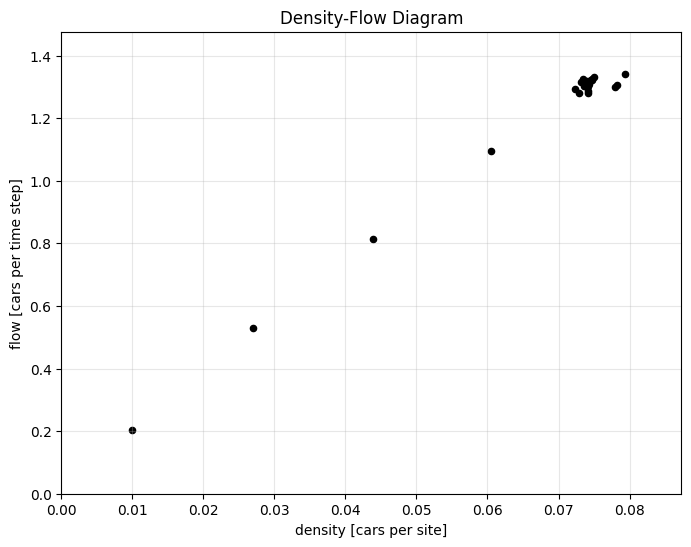

In [7]:
# model with density control
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


# dict to store different driver type(can also be used for reaction/...)
# make sure sapwn_weight sum up to 1
DRIVER_TYPES = {
    0: {  # Lorry
        'vmax': 3,
        'overtake_rate': 0,    
        'return_rate': 1,
        'spawn_weight': 0.1     
    },
    1: {  # Regular Cars
        'vmax': 5,
        'overtake_rate': 0.5,    
        'return_rate': 0.5,     
        'spawn_weight': 0.7  
    },
    2: {  # Fast Cars
        'vmax': 7,
        'overtake_rate': 0.7,    
        'return_rate': 0,
        'spawn_weight':0.2       
    }
}

# get the gap 
def get_gap_ahead_same_lane(lane, pos):
    # check if the current position is valid
    if pos < 0 or pos >= len(lane):
        raise ValueError("Out of range")
    
    # find all the cars ahead, if it's there is car in next position, return 0(no gap)
    next_car_positions = np.where(lane[pos+1:] >= 0)[0]
    
    # if no car in front of it
    if len(next_car_positions) == 0:
        return 100
    
    return next_car_positions[0]

def get_gaps_other_lane(lanes, lane_idx, pos):
    other_lane = lanes[1 - lane_idx]
    
    if pos < 0 or pos >= len(lanes[0]):
        raise ValueError("Current position is out of range")
    
    #if there is a vehicle on a neighbouring site both return -1
    if other_lane[pos] >= 0:
        return -1, -1
    
    # Forward gap:
    next_car_positions = np.where(other_lane[pos+1:] >= 0)[0]
    
    # if no car in front of it
    if len(next_car_positions) == 0:
        forward_gap = 100
    else:
        forward_gap = next_car_positions[0]  
        
    # Backward gap: 
    prev_car_positions = np.where(other_lane[:pos] >= 0)[0]
    
    # no car at back
    if len(prev_car_positions) == 0:
        backward_gap = 100  
    else:
        backward_gap = pos - prev_car_positions[-1] - 1  
    
    return forward_gap, backward_gap

# check whether should change the lane
def should_change_lane(lanes, lane_idx, pos, driver_types):
    if lanes[lane_idx][pos] == -1:
        return False
    
    driver_type = driver_types[lane_idx][pos]
    if driver_type == -1:
        return False

    forward_gap = get_gap_ahead_same_lane(lanes[lane_idx], pos)
    adj_forward_gap, adj_backward_gap = get_gaps_other_lane(lanes, lane_idx, pos)
    
    v = lanes[lane_idx][pos]
    
    driver_params = DRIVER_TYPES[driver_type]
    overtake_rate = driver_params['overtake_rate']
    return_rate = driver_params['return_rate']
    
    # When in right lane (lane_idx = 1), check if should return to left lane
    if lane_idx == 1:  
        if (forward_gap >= v + 2 and            # T1
            adj_forward_gap >= v + 1 and      # T2
            adj_backward_gap >= 6 and           # T3
            np.random.random() < return_rate):  # T4
            return True

    # overtake
    if (forward_gap < v + 1 and                  # T1
        adj_forward_gap > v + 1 and            # T2
        adj_backward_gap >= 6 and                # T3
        np.random.random() < overtake_rate):  # T4
        return True
    
    return False 

# updatge change of lane
def change_lanes(lanes, driver_types):
    length = len(lanes[0])
    changes = []
    
    # record the index and position that would change lane
    for lane_idx in range(2):
        for pos in range(length):
            if should_change_lane(lanes, lane_idx, pos, driver_types):
                changes.append((lane_idx, pos))
                
    # change lane
    for lane_idx, pos in changes:
        if lanes[lane_idx][pos] >= 0:
            # get velocity and driver type
            v = lanes[lane_idx][pos]
            driver_type = driver_types[lane_idx][pos]
            
            # change lane
            lanes[lane_idx][pos] = -1
            driver_types[lane_idx][pos] = -1
            
            lanes[1-lane_idx][pos] = v
            driver_types[1-lane_idx][pos] = driver_type
    
    return lanes, driver_types

# update velocities for each step
def update_velocities(lanes, driver_types, p):
    for lane_idx in range(2):
        for pos in range(len(lanes[0])):
            if lanes[lane_idx][pos] >= 0:
                driver_type = driver_types[lane_idx][pos]

                vmax = DRIVER_TYPES[driver_type]['vmax']
                v = lanes[lane_idx][pos]
                
                # Acceleration
                if v < vmax:
                    v += 1
                
                # Slowing down
                gap = get_gap_ahead_same_lane(lanes[lane_idx], pos)
                v = min(v, gap)
                
                # Slowing down
                if v > 0 and np.random.random() < p:
                    v -= 1
                
                lanes[lane_idx][pos] = v
    
    return lanes

# move cars after get velocity
def move_cars(lanes, driver_types):
    length = len(lanes[0])
    new_lanes = [np.full(length, -1), np.full(length, -1)]
    new_driver_types = [np.full(length, -1), np.full(length, -1)]
    
    for lane_idx in range(2):
        for pos in range(length):
            if lanes[lane_idx][pos] >= 0:
                v = lanes[lane_idx][pos]
                new_pos = pos + v
                
                if new_pos < length:
                    new_lanes[lane_idx][new_pos] = v
                    new_driver_types[lane_idx][new_pos] = driver_types[lane_idx][pos]
    
    return new_lanes, new_driver_types

# add car
def add_new_car_with_density_control(lanes, driver_types, target_density):
    length = len(lanes[0])
    current_cars = sum(sum(lane >= 0) for lane in lanes)
    current_density = current_cars / (2 * length)

    if current_density < target_density:
        # instead of generate new cars in both lane, we choose a lane to add new car, higher possibility to generate in left lane(slow lane)
        generate_rate = [0.7, 0.3]
        lane_idx = np.random.choice([0, 1], p=generate_rate)
        
        forward_gap = get_gap_ahead_same_lane(lanes[lane_idx], 0)
        adj_forward_gap, _ = get_gaps_other_lane(lanes, lane_idx, 0)
        # if the start pos is empty
        if lanes[lane_idx][0] == -1:
            weights = [info['spawn_weight'] for info in DRIVER_TYPES.values()]
            new_driver_type = np.random.choice(len(DRIVER_TYPES), p=weights)
            driver_params = DRIVER_TYPES[new_driver_type]
            
            # since it's on highway, we want the new car with a initial speed
            min_entry_speed = int(driver_params['vmax'] * 0.5)      # lower bound
            max_entry_speed = int(driver_params['vmax'])            # upper bound
            
            # to make sure it is safe when add new cars
            safe_entry_speed = min(max_entry_speed, forward_gap - 1, adj_forward_gap - 1)
            
            # add car when its initial speed greater than min_entry_speed, smaller than safe_entry_speed
            if safe_entry_speed >= min_entry_speed:
                initial_speed = np.random.randint(min_entry_speed, safe_entry_speed + 1, dtype=int)
                lanes[lane_idx][0] = initial_speed
                driver_types[lane_idx][0] = new_driver_type
    
    return lanes, driver_types

# code for update traffic for each step
def update_traffic_with_density(lanes, driver_types, target_density, p=0.3):
    # change lane
    lanes, driver_types = change_lanes(lanes, driver_types)
    
    # update velocities
    lanes = update_velocities(lanes, driver_types, p)
    
    # move cars
    lanes, driver_types = move_cars(lanes, driver_types)
    
    # add new car at start point
    lanes, driver_types = add_new_car_with_density_control(lanes, driver_types, target_density)
    
    return lanes, driver_types

# code for calculate traffic measurements
def calculate_traffic_measurements(lanes_history, interval_size):
    measure_interval = lanes_history[-interval_size:]
    length = len(measure_interval[0][0])
    measure_point = length // 2
    
    total_flow = 0
    num_cars = 0
    total_velocity = 0
    
    current_lanes = lanes_history[-1]
    for lane_idx in range(2):
        car_positions = np.where(current_lanes[lane_idx] >= 0)[0]
        car_velocities = current_lanes[lane_idx][car_positions]
        
        num_cars += len(car_positions)
        total_velocity += np.sum(car_velocities)
        
        for lanes in measure_interval:
            flow = 0    # flow for each step
            for lane_idx in range(2):
                car_positions = np.where(lanes[lane_idx] >= 0)[0]
                for pos in car_positions:
                    velocity = lanes[lane_idx][pos]
                    if velocity > 0:
                        start_pos = pos - velocity
                        if start_pos <= measure_point < pos:
                            flow += 1
                            
            total_flow += flow
            
    avg_flow = total_flow / interval_size
    density = num_cars / (2 * length)  
    avg_velocity = total_velocity / num_cars if num_cars > 0 else 0

    return avg_flow, density, avg_velocity

# run the simulation
def simulate_traffic_with_density_control(length, t0, steps, target_density, interval_size = 10, p=0.3):
    lanes = [np.full(length, -1), np.full(length, -1)]  
    driver_types = [np.full(length, -1), np.full(length, -1)]  
    
    # first run the code t0 times, and begin the collection of data after the first t0 time steps
    for _ in range(t0):
        lanes, driver_types = update_traffic_with_density(lanes, driver_types, target_density, p)
    
    flows = []
    densities = []
    velocities = []
    
    lanes_history = []
    driver_types_history = []

    
    # simulate and start to record the data
    for step in range(steps):
        lanes_history.append(lanes)
        driver_types_history.append(driver_types)
        
        if len(lanes_history) >= interval_size:
            flow, density, velocity = calculate_traffic_measurements(lanes_history, interval_size)
            flows.append(flow)
            densities.append(density)
            velocities.append(velocity)
            
        lanes, driver_types = update_traffic_with_density(lanes, driver_types, target_density, p)
        
    return flows, densities, velocities, lanes_history, driver_types_history
#_, _, _, lane_history, _=simulate_traffic_with_density_control(length=20, t0=10, steps=3, target_density=1, interval_size=1, p=0)
#print(lane_history)

def simulate_multiple_densities(length=1000, t0=500, steps=1000, interval_size = 1):
    density_range = np.linspace(0.01, 0.5, 30)
    
    flows_data = []
    densities_data = []
    
    # one thing to notice, target_density is not actual density.
    for target_density in tqdm(density_range, desc="Simulating"):
    #for target_density in density_range:
        flows, densities, _, _, _ = simulate_traffic_with_density_control(length, t0, steps, target_density, interval_size, p=0)
        
        flows_data.append(np.mean(flows))
        densities_data.append(np.mean(densities))
    
    #print(flows_data, densities_data)
    plt.figure(figsize=(8, 6))
    plt.scatter(densities_data, flows_data, alpha=1, s=20, color='black')

    plt.xlabel('density [cars per site]')
    plt.ylabel('flow [cars per time step]')
    plt.title('Density-Flow Diagram')
    plt.grid(True, alpha=0.3)
    plt.xlim(0, max(densities_data) * 1.1)
    plt.ylim(0, max(flows_data) * 1.1)
    
    plt.show()

simulate_multiple_densities()

In [6]:
from matplotlib.animation import FuncAnimation, PillowWriter
import matplotlib.pyplot as plt
import numpy as np


road_length = 200
target_density=0.2
lanes = [np.full(road_length, -1), np.full(road_length, -1)]  
driver_types = [np.full(road_length, -1), np.full(road_length, -1)]  

# Pre-run the simulation
t0 = 1000
for _ in range(t0):
    lanes, driver_types = update_traffic_with_density(lanes, driver_types, target_density, p= 0.3)


fig, ax = plt.subplots(figsize=(12, 4))
ax.set_xlim(-2, road_length)  
ax.set_ylim(-0.1, 0.6)
ax.yaxis.set_visible(False)

scatter_lanes = [None, None]
velocity_texts = []

def init():
    # Draw road lanes, slow on top(left)
    ax.plot([-2, road_length], [0.3, 0.3], 'k-', lw=1)  #slow lane
    ax.plot([-2, road_length], [0, 0], 'k-', lw=1)      #fast lane
        
    ax.set_title('Two-Lane Traffic Flow Simulation (Left-hand Traffic)')
    
    ax.text(road_length/2, 0.5, 'Drive From Left to Right', ha='center', va='center', fontsize=12, color='black', fontweight='bold')
    ax.text(-2, 0.3, 'Slow Lane (Left)', ha='right', va='center')
    ax.text(-2, 0, 'Fast Lane (Right)', ha='right', va='center')
    
    legend_elements = [
        plt.scatter([], [], c='blue', s=100, label='Lorry'),
        plt.scatter([], [], c='green', s=100, label='Regular Cars'),
        plt.scatter([], [], c='red', s=100, label='Fast Cars')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    


def animate(frame):
    global lanes, driver_types, velocity_texts, scatter_lanes
    
    # to remove staff in last frame
    for text in velocity_texts:
        text.remove()
    velocity_texts = []
    
    for scatter in scatter_lanes:
        if scatter:
            scatter.remove()
    scatter_lanes = [None, None]

    lanes, driver_types = update_traffic_with_density(lanes, driver_types, target_density, p=0.3)
    

    for lane_idx in range(2):
        car_positions = np.where(lanes[lane_idx] >= 0)[0]
        
        if len(car_positions) > 0:
            y_positions = np.full_like(car_positions, 0.3 - lane_idx * 0.3, dtype=float)
            
            colors = []
            for pos in car_positions:
                driver_type = driver_types[lane_idx][pos]
                if driver_type == 0:
                    colors.append('blue')
                elif driver_type == 1:
                    colors.append('green')
                else:
                    colors.append('red')
            
            scatter_lanes[lane_idx] = ax.scatter(car_positions, y_positions, c=colors, s=100)
            
            for pos, y in zip(car_positions, y_positions):
                velocity = lanes[lane_idx][pos]
                text = ax.text(pos, y + 0.05, str(velocity), ha='center', va='center', fontsize=8)
                velocity_texts.append(text)
    


anim = FuncAnimation(fig, animate, init_func=init, frames=100, interval=200)

writer = PillowWriter(fps=3)
anim.save('two_lane_traffic_simulation.gif', writer=writer)
plt.close()
